### Initial Preprocessing - Revert to original, non-json form
#### Borrowed from Kaggle Kernel

In [51]:
#https://www.kaggle.com/sohier/getting-imdb-kernels-working-with-tmdb-data
#https://www.kaggle.com/fabiendaniel/film-recommendation-engine

# Load Packages
#-------------------------------------------------------------------------
import pandas as pd
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nltk
!pip install fuzzywuzzy
!pip install wordcloud
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()



# Functions to Read in and Clean Data
#-------------------------------------------------------------------------
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

#-------------------------------------------------------------------------
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#-------------------------------------------------------------------------
# Columns that existed in the IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]
#-------------------------------------------------------------------------
# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

#-------------------------------------------------------------------------
def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

#-------------------------------------------------------------------------
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

#-------------------------------------------------------------------------
def pipe_flatten_names(keywords):
    return ','.join([x['name'] for x in keywords])

#-------------------------------------------------------------------------
def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies





In [52]:
#-------------------------------------------------------------------------
# Read in Data
#-------------------------------------------------------------------------
movies = load_tmdb_movies('C:/Users/jdine/Desktop/SYracuse/Term 6/Marketing Analytics/Final Project/tmdb_5000_movies.csv')
credits = load_tmdb_credits('C:/Users/jdine/Desktop/SYracuse/Term 6/Marketing Analytics/Final Project/tmdb_5000_credits.csv')
original_format = convert_to_original_format(movies, credits)

### Preprocessing

In [53]:
# Check for missing Values
#-------------------------------------------------------------------------
original_format.isnull().sum(axis=0) #Check Missing Values

budget                     0
genres                     0
homepage                3091
id                         0
plot_keywords              0
language                  86
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
gross                      0
duration                   2
spoken_languages           0
status                     0
tagline                  844
movie_title                0
vote_average               0
num_voted_users            0
title_year                 1
country                  174
director_name             30
actor_1_name              43
actor_2_name              53
actor_3_name              63
dtype: int64

In [54]:
# Remove unnecessary columns
#-------------------------------------------------------------------------
columns_to_kill = ['homepage', 'id']
#Remove 'homepage' column due to irrelevance to this task. Also ID since we already mapped and merged
original_format.drop(axis=1, columns= columns_to_kill, inplace= True)



In [55]:
# Remove Outliers
#-------------------------------------------------------------------------
np.where(original_format.budget == 92620000) #Movie with a 92mm budget in the 1920's??
np.where(original_format.title_year == 2017) #Only one movie's data for 2017. Get rid of
outliers = [2638, 4255] #col indices
original_format.drop(index=outliers, inplace=True)


In [56]:
# Check Data Structure
#-------------------------------------------------------------------------
print(original_format.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 4802
Data columns (total 24 columns):
budget                  4801 non-null int64
genres                  4801 non-null object
plot_keywords           4801 non-null object
language                4715 non-null object
original_title          4801 non-null object
overview                4798 non-null object
popularity              4801 non-null float64
production_companies    4801 non-null object
production_countries    4801 non-null object
release_date            4800 non-null object
gross                   4801 non-null int64
duration                4799 non-null float64
spoken_languages        4801 non-null object
status                  4801 non-null object
tagline                 3957 non-null object
movie_title             4801 non-null object
vote_average            4801 non-null float64
num_voted_users         4801 non-null int64
title_year              4800 non-null float64
country                 4628 non-null

### Exploratory Data Analysis

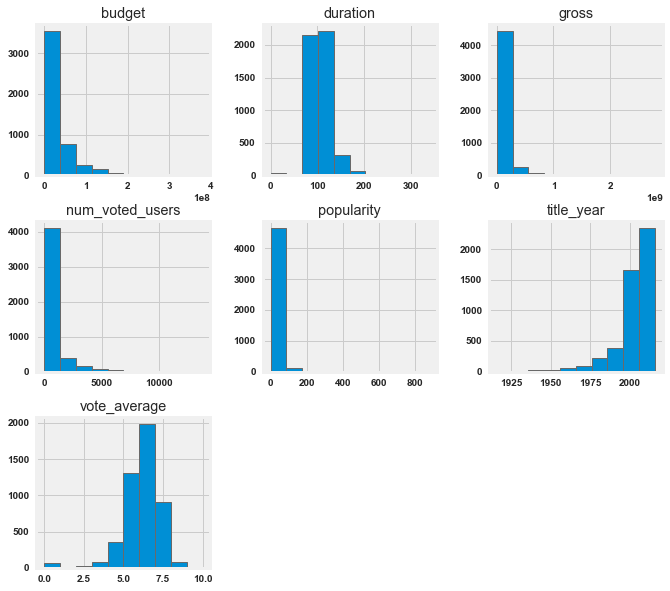

In [57]:
# Basic hists. of numeric variables
#-------------------------------------------------------------------------
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
original_format.hist()
plt.show()

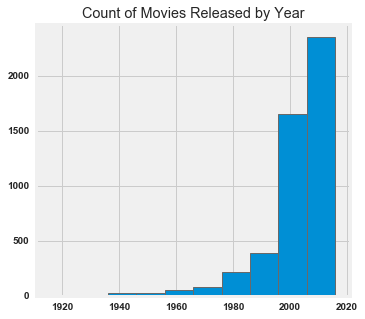

In [58]:
# Singular Hist of Movies released by year
#-------------------------------------------------------------------------
rcParams['figure.figsize'] = 5,5
original_format.title_year.hist()
plt.title('Count of Movies Released by Year')
plt.ylabel
plt.show()

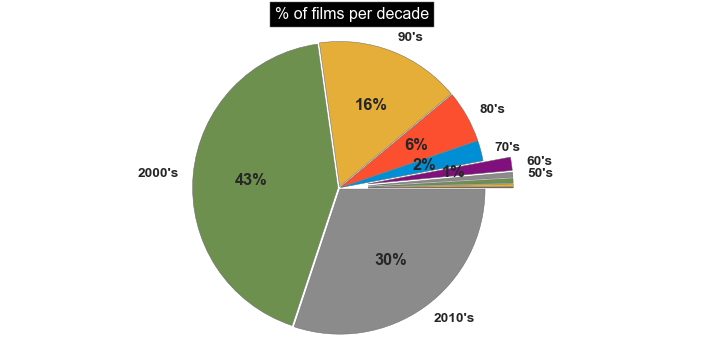

In [59]:
# Pi Chart of movies released by decade
#-------------------------------------------------------------------------
#Code borrowed from: https://www.kaggle.com/fabiendaniel/film-recommendation-engine

original_format['decade'] = original_format['title_year'].apply(lambda x:((x-1900)//10)*10)
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = original_format['title_year'].groupby(original_format['decade']).apply(get_stats).unstack()

sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
original_format.drop('decade', axis=1, inplace = True)


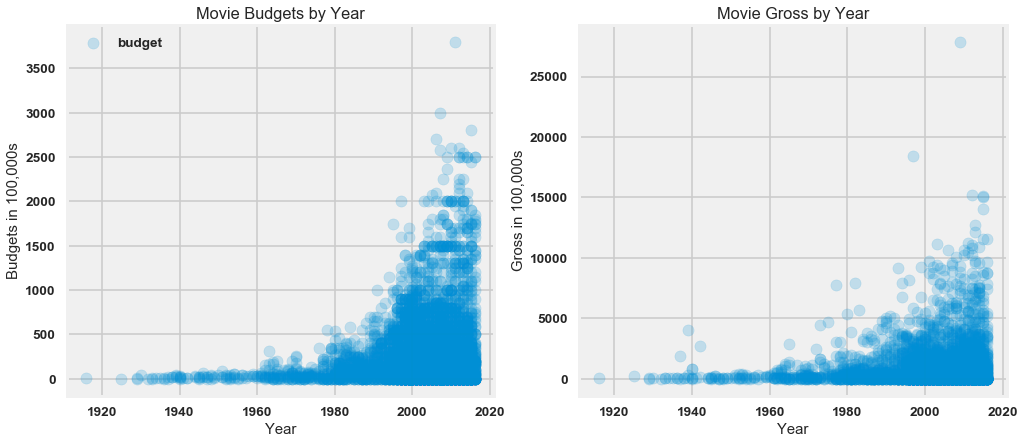

In [60]:
# Plots of Budget/Gross movement w/ temporal aspect
#-------------------------------------------------------------------------
rcParams['figure.figsize'] = 15,15
fig = plt.figure()
plt.subplot(2, 2, 1)        
plt.scatter(original_format.title_year, original_format.budget/100000, alpha= .2)
plt.title('Movie Budgets by Year')
plt.ylabel('Budgets in 100,000s')
plt.xlabel('Year')
plt.legend()
#-------------------------------------------------------------------------
plt.subplot(2, 2, 2)
plt.scatter(original_format.title_year, original_format.gross/100000, alpha= .2)
plt.title('Movie Gross by Year')
plt.ylabel('Gross in 100,000s')
plt.xlabel('Year')
plt.show()

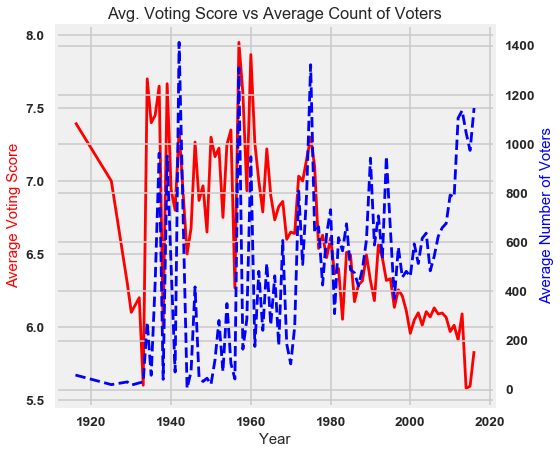

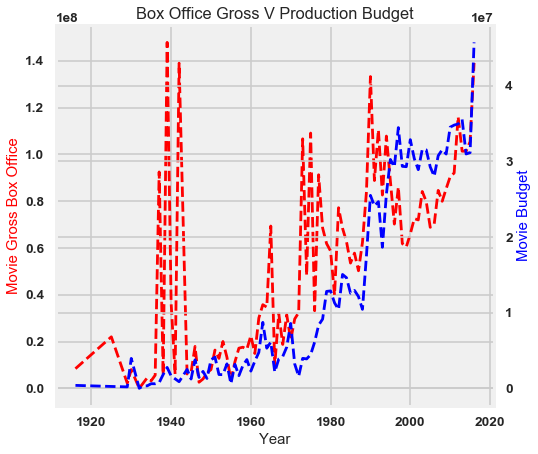

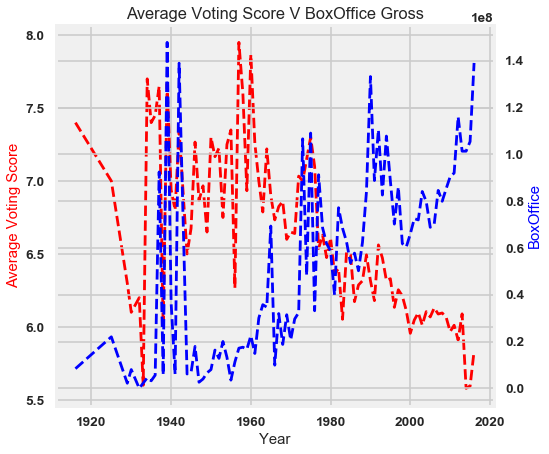

In [61]:
# MultiLevel plots 
#-------------------------------------------------------------------------
g = original_format.groupby('title_year').mean()
g = g.reset_index()
rcParams['figure.figsize'] = 7,7
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(g.iloc[:,0], g.vote_average, 'r')
ax2.plot(g.iloc[:,0], g.num_voted_users, 'b', ls= '--')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Voting Score', color='r')
ax2.set_ylabel('Average Number of Voters', color='b')
plt.title('Avg. Voting Score vs Average Count of Voters')
plt.show()

#Check out Outlier around 1930
#-------------------------------------------------------------------------
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(g.iloc[:,0], g.gross, 'r', ls= '--')
ax2.plot(g.iloc[:,0], g.budget, 'b', ls= '--')
ax1.set_xlabel('Year')
ax1.set_ylabel('Movie Gross Box Office', color='r')
ax2.set_ylabel('Movie Budget', color='b')
plt.title('Box Office Gross V Production Budget') 
plt.show()


#As the movie budget goes up, the average user rating goes down
#-------------------------------------------------------------------------
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(g.iloc[:,0], g.vote_average, 'r', ls= '--')
ax2.plot(g.iloc[:,0], g.gross, 'b', ls= '--')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Voting Score', color='r')
ax2.set_ylabel('BoxOffice', color='b')
plt.title('Average Voting Score V BoxOffice Gross') 
plt.show()

In [62]:
# Creating a variable that uses quantiles as a cutoff to determine BO success or failure
#-------------------------------------------------------------------------
#Assuming a simple profitability measure, such as: Gross - Budget
original_format['profit'] = original_format.gross - original_format.budget
#Splitting profit into 5 equally sized bins based on quantile
from scipy import stats
bin_edges = stats.mstats.mquantiles(original_format.profit, [.1,.2,.3,.4,.5,.6,.7,.8,.9])


original_format['BO.Success'] = np.where(original_format.profit <bin_edges[3], -1,
                            np.where(original_format.profit > bin_edges[3], 1, 0))






# Create Content Based Reco Engine

Popularity based recommendation engines will simply return movie recommendations based on similarity of popularity, as defined by the popularity or average vote metric. This is often a poor approach to handling recommendations - Just because a user likes a particular popular product, there is no ground truth to the notion that they will only like popular products in the future. Further more, reco engines are designed to produce incremental usage/purchases. Showing only popular products that a user/purchaser might have otherwise purchased without the use of a reco engine defies the purpose. 


I want to create a recommender based on a variety of different similarities (popularity based, keyword based, overview based, concatenation of these methods. Think about creating a class?

In [31]:
#Import TfIdfVectorizer from scikit-learn
#https://sites.temple.edu/tudsc/2017/03/30/measuring-similarity-between-texts-in-python/
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import time
import nltk, string, numpy
import Filmcleansing
from Filmcleansing import convert_to_original_format
import locale
locale.setlocale( locale.LC_ALL, 'English_United States.1252' )



######################################################################
#Create Weighted Rating Feature
#weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 
#https://help.imdb.com/article/imdb/track-movies-tv/faq-for-imdb-ratings/G67Y87TFYYP6TWAV#
C = original_format['vote_average'].mean()
m = original_format['num_voted_users'].quantile(0.85)
def weighted_rating(x, m=m, C=C):
    '''
    weighted rating that accounts for voting averages and number of user votes
    m & C are derived based on the data  
    '''
    v = x['num_voted_users']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)


######################################################################
def fuzzymatching_title(title):
    '''
    input:: User input Movie Title
    returns:: Closest Match to user input
    '''
    movie_titles = original_format['movie_title']
    potential_matches = process.extractOne(title, movie_titles)
    return str(potential_matches[0])
    
######################################################################    
def clean_data(x):
    ''' 
    Converts all data to lower case and removes punctuation for stemming/lemmatization
    '''
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        

######################################################################    
#https://sites.temple.edu/tudsc/2017/03/30/measuring-similarity-between-texts-in-python/
#Normalize by lemmatization:
lemmer = nltk.stem.WordNetLemmatizer()
def LemTokens(tokens):
     return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
     return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

#Normalize by stemming:
stemmer = nltk.stem.porter.PorterStemmer()
def StemTokens(tokens):
    return [stemmer.stem(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def StemNormalize(text):
    return StemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

######################################################################    



original_format['score'] = original_format.apply(weighted_rating, axis=1)
original_format['cast'] = original_format['actor_1_name'] + ' ' \
    + original_format['actor_2_name']+ ' ' + original_format['actor_3_name']

original_format['all'] = original_format['cast'] + ' ' \
    + original_format['director_name']+ ' ' + original_format['plot_keywords']+ ' ' \
    + original_format['genres']+ ' ' + original_format['overview']


######################################################################
class Recommend():
    
    def by_synopsis(title, number_of_recommendations, token, verbose = True):
        

        title = fuzzymatching_title(title) #Fuzzymatching on title incase user input error

        if verbose:
            print("Querying films similar to:" + ' ' + '\033[1m' +  str(title) + '\033[0m') #Display text output
            print("Criteria for Matching:" + '\033[1m' + 'Cosine Similarity of Plot Overview w/ Box Office Profit' + '\033[0m')

        newdf = original_format.copy() #Make a copy of the original dataframe to preserve objects
        newdf['score'] = newdf.apply(weighted_rating, axis=1)
        #Similarity based on Synopsis
        #Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
        tfidf = TfidfVectorizer(tokenizer = token, stop_words='english')
        #Replace NaN with an empty string
        newdf['overview'] = newdf['overview'].fillna('')
        #Construct the required TF-IDF matrix by fitting and transforming the data
        tfidf_matrix = tfidf.fit_transform(newdf['overview'])
        # Compute the cosine similarity matrix
        synopsis_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
        #Construct a reverse map of indices and movie titles
        indices = pd.Series(newdf.index, index=newdf['movie_title']).drop_duplicates()
        # Get the index of the movie that matches the title
        idx = indices[title]
        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(synopsis_sim[idx]))
        # Sort the movie based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the 100 most similar movies
        sim_scores = sim_scores[1:21]
        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]
        # Return the top 5 most similar movies w/ popularity factored in
        cols = ['movie_title', 'score', 'profit']
        newdf = newdf[cols].iloc[movie_indices].sort_values('score', ascending = False)
        newdf1 = newdf['movie_title'].head(number_of_recommendations)
        rangeofmovies = range(1,number_of_recommendations +1)
        profit = newdf['profit'][0:number_of_recommendations]

        for rang, reco, p in zip(rangeofmovies,newdf1, profit):
            time.sleep(.5)
            print('{} :{} | {} '.format(str(rang), str(reco), locale.currency( p, grouping = True )))

            
    def by_plotkeywords(title, number_of_recommendations, token, verbose = True):

        title = fuzzymatching_title(title) #Fuzzymatching on title incase user input error

        if verbose:
            print("Querying films similar to:" + ' ' + '\033[1m' +  str(title) + '\033[0m') #Display text output
            print("Criteria for Matching:" + '\033[1m' + 'Cosine Similarity of Plot Keywords w/ Box Office Profit' + '\033[0m')

        newdf = original_format.copy() #Make a copy of the original dataframe to preserve objects
        #Similarity based on Synopsis
        #Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
        tfidf = TfidfVectorizer(tokenizer = token, stop_words='english')
        #Replace NaN with an empty string
        newdf['plot_keywords'] = newdf['plot_keywords'].fillna('')
        #Construct the required TF-IDF matrix by fitting and transforming the data
        tfidf_matrix = tfidf.fit_transform(newdf['plot_keywords'])
        # Compute the cosine similarity matrix
        keyword_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
        #Construct a reverse map of indices and movie titles
        indices = pd.Series(newdf.index, index=newdf['movie_title']).drop_duplicates()
        # Get the index of the movie that matches the title
        idx = indices[title]
        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(keyword_sim[idx]))
        # Sort the movie based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the 100 most similar movies
        sim_scores = sim_scores[1:21]
        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]
        # Return the top 5 most similar movies w/ popularity factored in
        cols = ['movie_title', 'score', 'profit']
        newdf = newdf[cols].iloc[movie_indices].sort_values('score', ascending = False)
        newdf1 = newdf['movie_title'].head(number_of_recommendations)
        rangeofmovies = range(1,number_of_recommendations +1)
        profit = newdf['profit'][0:number_of_recommendations]

        for rang, reco, p in zip(rangeofmovies,newdf1, profit):
            time.sleep(.5)
            print('{} :{} | {} '.format(str(rang), str(reco), locale.currency( p, grouping = True )))
            
    def by_cast(title, number_of_recommendations, token, verbose = True):
        title = fuzzymatching_title(title) #Fuzzymatching on title incase user input error
        if verbose:
            print("Querying films similar to:" + ' ' + '\033[1m' +  str(title) + '\033[0m') #Display text output
            print("Criteria for Matching:" + '\033[1m' + 'Cosine Similarity Cast w/ Box Office Profit' + '\033[0m')

        newdf = original_format.copy() #Make a copy of the original dataframe to preserve objects
        #Similarity based on Synopsis
        #Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
        tfidf = TfidfVectorizer(tokenizer = token, stop_words='english')
        #Replace NaN with an empty string
        newdf['cast'] = newdf['cast'].fillna('')
        #Construct the required TF-IDF matrix by fitting and transforming the data
        tfidf_matrix = tfidf.fit_transform(newdf['cast'])
        # Compute the cosine similarity matrix
        keyword_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
        #Construct a reverse map of indices and movie titles
        indices = pd.Series(newdf.index, index=newdf['movie_title']).drop_duplicates()
        # Get the index of the movie that matches the title
        idx = indices[title]
        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(keyword_sim[idx]))
        # Sort the movie based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the 100 most similar movies
        sim_scores = sim_scores[1:21]
        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]
        # Return the top 5 most similar movies w/ popularity factored in
        cols = ['movie_title', 'score', 'profit']
        newdf = newdf[cols].iloc[movie_indices].sort_values('score', ascending = False)
        newdf1 = newdf['movie_title'].head(number_of_recommendations)
        rangeofmovies = range(1,number_of_recommendations +1)
        profit = newdf['profit'][0:number_of_recommendations]

        for rang, reco, p in zip(rangeofmovies,newdf1, profit):
            time.sleep(.5)
            print('{} :{} | {} '.format(str(rang), str(reco), locale.currency( p, grouping = True )))
    
    def by_allcats(title, number_of_recommendations, token, verbose = True):
        title = fuzzymatching_title(title) #Fuzzymatching on title incase user input error
        if verbose:
            print("Querying films similar to:" + ' ' + '\033[1m' +  str(title) + '\033[0m') #Display text output
            print("Criteria for Matching:" + '\033[1m' + 'Cosine Similarity of All Categorical Variables w/ Box Office Profit' + '\033[0m')

        newdf = original_format.copy() #Make a copy of the original dataframe to preserve objects

        #Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
        count = CountVectorizer(tokenizer = token, stop_words='english')
        #Replace NaN with an empty string
        newdf['all'] = newdf['all'].fillna('')
        count_matrix = count.fit_transform(newdf['all'])
        cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

        #Construct a reverse map of indices and movie titles
        indices = pd.Series(newdf.index, index=newdf['movie_title']).drop_duplicates()
        # Get the index of the movie that matches the title
        idx = indices[title]
        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim2[idx]))
        # Sort the movie based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the 100 most similar movies
        sim_scores = sim_scores[1:21]
        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]
        # Return the top 5 most similar movies w/ popularity factored in
        cols = ['movie_title', 'score', 'profit']
        newdf = newdf[cols].iloc[movie_indices].sort_values('score', ascending = False)
        newdf1 = newdf['movie_title'].head(number_of_recommendations)
        rangeofmovies = range(1,number_of_recommendations +1)
        profit = newdf['profit'][0:number_of_recommendations]

        for rang, reco, p in zip(rangeofmovies,newdf1, profit):
            time.sleep(.5)
            print('{} :{} | {} '.format(str(rang), str(reco), locale.currency( p, grouping = True )))
            
            



In [33]:
title = 'Saving Private Ryan'
numrecos = 5
token = LemNormalize

Recommend.by_synopsis(title = title, number_of_recommendations= numrecos, token= LemNormalize)
Recommend.by_plotkeywords(title = title, number_of_recommendations= numrecos, token= LemNormalize)
Recommend.by_cast(title = title, number_of_recommendations= numrecos, token= LemNormalize)
Recommend.by_allcats(title = title, number_of_recommendations= numrecos, token= LemNormalize)

Querying films similar to: Saving Private Ryan
Criteria for Matching:Cosine Similarity of Plot Overview w/ Box Office Profit
1 :Apocalypse Now | $57,960,381.00 
2 :2 Guns | $70,940,411.00 
3 :Brothers | $17,318,349.00 
4 :Public Enemies | $134,104,620.00 
5 :Evil Dead | $80,542,952.00 
Querying films similar to: Saving Private Ryan
Criteria for Matching:Cosine Similarity of Plot Keywords w/ Box Office Profit
1 :The Imitation Game | $219,555,708.00 
2 :Enemy at the Gates | $28,976,270.00 
3 :Spy Game | $51,049,560.00 
4 :Joyeux Noël | ($4,290,845.00) 
5 :The Best Years of Our Lives | $21,550,000.00 
Querying films similar to: Saving Private Ryan
Criteria for Matching:Cosine Similarity Cast w/ Box Office Profit
1 :Good Will Hunting | $215,933,435.00 
2 :Furious 7 | $1,316,249,360.00 
3 :Ocean's Eleven | $365,717,150.00 
4 :The Iron Giant | ($46,840,695.00) 
5 :Apollo 13 | $303,237,933.00 
Querying films similar to: Saving Private Ryan
Criteria for Matching:Cosine Similarity of All Catego

#### Wordcloud Stuff

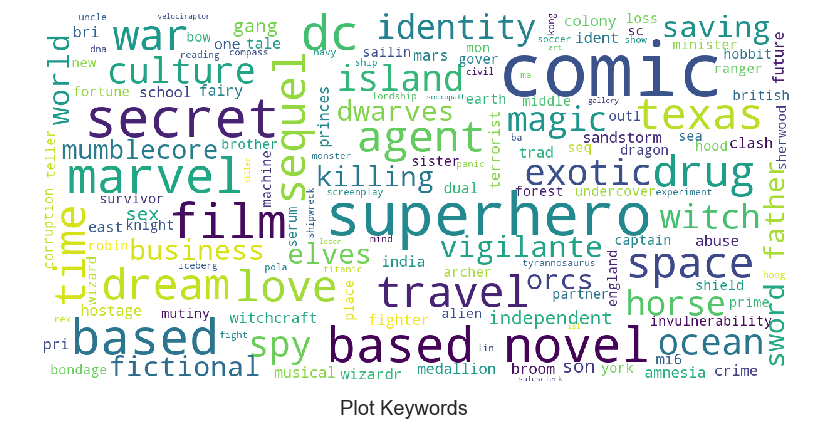

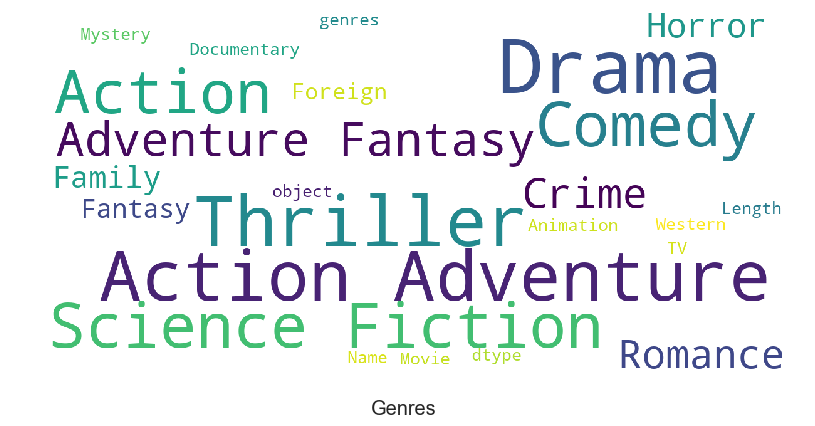

ValueError: list.remove(x): x not in list

In [63]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
    

original_format.dropna(how='all')   
show_wordcloud(original_format['plot_keywords'],title = 'Plot Keywords')

show_wordcloud(original_format['genres'], title = 'Genres')
actor = list(original_format.actor_1_name)
actor.remove('nan')

show_wordcloud(actor, title = 'Actor_Lead')



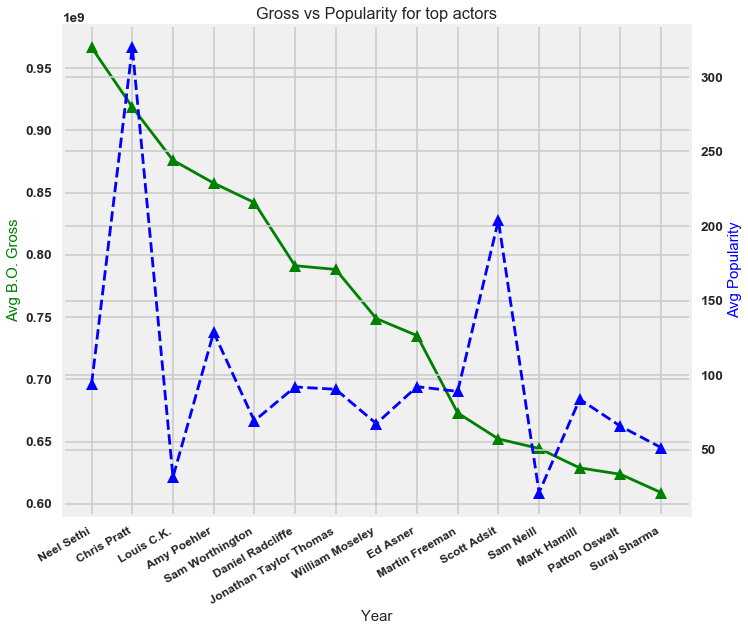

In [64]:
pd.options.display.float_format = '{:.2f}'.format
cols = [ 'gross', 'popularity']
import matplotlib.pyplot as plt
sortdf = pd.DataFrame(original_format[cols].groupby(by = original_format['actor_1_name']).mean())
sortdf = sortdf.reset_index()
sortdf = sortdf.sort_values('gross', ascending=False).head(15)
sortdf.gross = np.round(sortdf.gross, 15)
# MultiLevel plots 
pd.options.display.float_format = '{:.2f}'.format

rcParams['figure.figsize'] = 10,10
plt.rc('xtick', labelsize =12)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(sortdf.iloc[:,0], sortdf.gross, 'g', marker = '^')
ax2.plot(sortdf.iloc[:,0], sortdf.popularity, 'b', ls= '--', marker = '^')
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg B.O. Gross', color='g')
ax2.set_ylabel('Avg Popularity', color='b')
plt.title('Gross vs Popularity for top actors')
fig.autofmt_xdate()
plt.show()

#### Correlation 

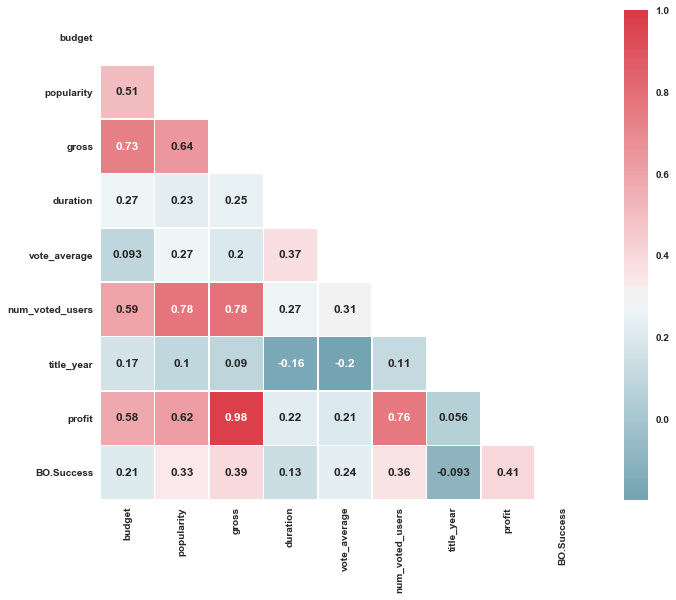

In [65]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = original_format.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=.3,
            square=True, linewidths=.5, annot=True, fmt='.2g',cbar_kws={"shrink": 1})



### Logit

In [66]:
original_format1 = original_format.copy()

f = lambda x: x["genres"].split(",")[0]
original_format1["splitgenre"] = original_format1.apply(f, axis=1)


#original_format1 = original_format1[original_format1['title_year'] > 2000] #IF only looking at 2000 onwards

In [67]:
original_format1 = original_format1.reset_index()
filter_values = [1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010, 2020] 
original_format1.title_year = pd.cut(original_format1.title_year, bins=filter_values)
original_format1 = original_format1[original_format1.budget !=0]
original_format1.budget = np.log(original_format1.budget)
filter_values = [60,120,180,240,300,360,420] 
original_format1.duration = pd.cut(original_format1.duration, bins=filter_values)


colstodummy = ['duration' , 'title_year', 'splitgenre', 'language', 'country', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name']

dums = pd.DataFrame(pd.get_dummies(original_format1[colstodummy]))
dums = dums.reset_index()
newdf = pd.merge(original_format1, dums, on= 'index')



In [68]:
colstodrop = [ 'index', 'genres', 'plot_keywords',
              'language', 'original_title',
              'overview', 'popularity', 'production_companies',
              'production_companies', 'production_countries',
              'release_date', 'tagline', 
              'movie_title', 'vote_average',
              'vote_average',
              'num_voted_users', 'spoken_languages', 'country', 'status', 'actor_1_name',
             'actor_2_name', 'actor_3_name', 'BO.Success', 'director_name', 'splitgenre', 'title_year', 'duration']

newdf =newdf.drop(colstodrop, axis=1)
              
              

In [69]:
avg = np.median(newdf['gross'] - newdf['budget'])
newdf['profitable'] = np.where(newdf['gross']-newdf['budget'] < avg, 0, 1)
newdf = newdf.drop([ 'gross', 'profit'], axis=1)
newdf = newdf.fillna(0)



In [71]:
y = newdf.iloc[:,-1]
x = newdf.copy()
x = x.drop('profitable', axis=1)


from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size = 0.2, random_state=42)

In [94]:
import sklearn
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(xtrain, ytrain)


0.7261724659606656
             precision    recall  f1-score   support

          0       0.74      0.69      0.71       325
          1       0.72      0.76      0.74       336

avg / total       0.73      0.73      0.73       661



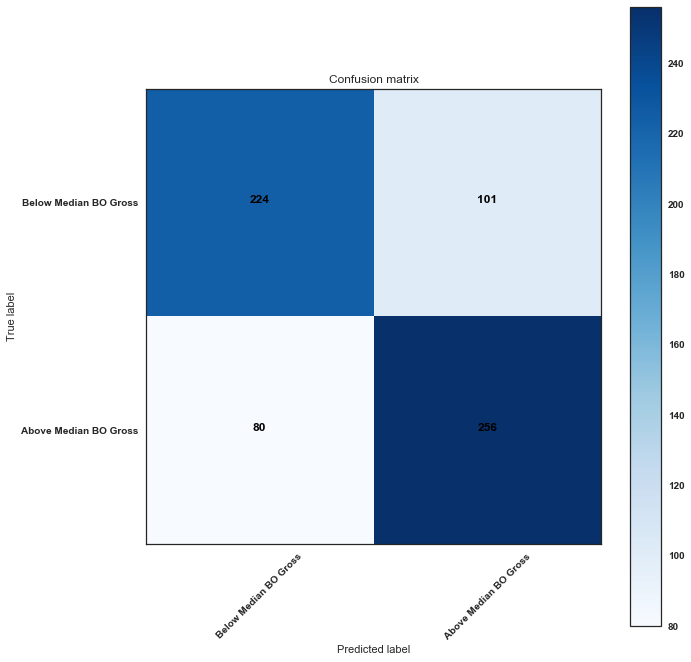

In [73]:
preds = model.predict(xtest)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# compute the confusion matrix
confusion_mtx = confusion_matrix(ytest, preds) 
# plot the confusion matrix

plot_confusion_matrix(confusion_mtx,  classes = ['Below Median BO Gross', 'Above Median BO Gross'])
print(accuracy_score(ytest, preds))
print(classification_report(ytest, preds))



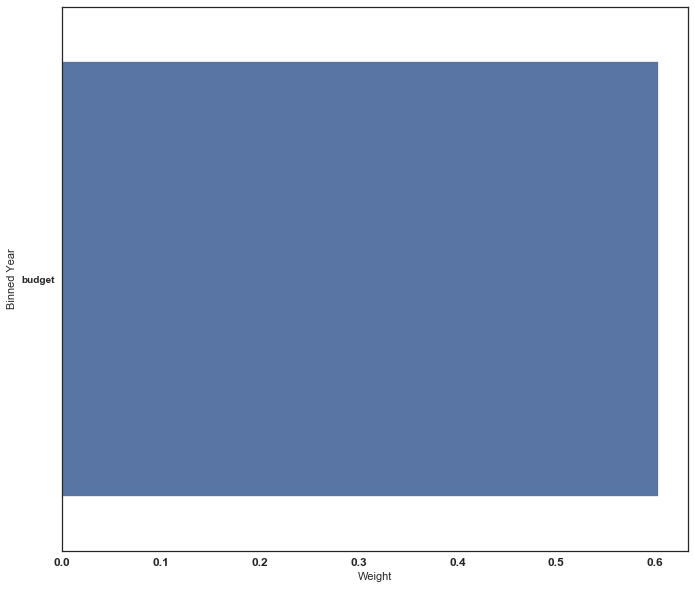

In [93]:
xtrain1 = xtrain

weights = pd.DataFrame(model.coef_.reshape(7972,1))
cols = pd.Series(xtrain1.columns)

weightsdf = pd.DataFrame(columns = ['weights', 'cols'])
weightsdf['cols'] = cols
weightsdf['weights'] = weights

weightsdf = weightsdf[weightsdf['cols'].str.contains('budget')]
weightsdf = weightsdf.sort_values(by = 'weights', ascending = False)
weightsdf = weightsdf [:50]
pd.options.display.float_format = '{:.2f}'.format

rcParams['figure.figsize'] = 10,10
plt.rc('xtick', labelsize =12)
sns.barplot(x = weightsdf['weights'], y = weightsdf['cols'])
plt.ylabel('Binned Year')
plt.xlabel('Weight')
plt.show()




newdf['profitable'].hist(bins =10)
newdf.groupby(by='profitable').count()